In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import colorsys

# ===== LOAN PARAMETERS - MODIFY THESE =====
principal = 300000  # Loan amount
annual_rate = 6.5  # Annual interest rate (%)
years = 30  # Original loan term in years
base_payment = 1896.20  # Your minimum monthly payment

# Extra payment scenarios to compare
extra_payments = [0, 100, 200, 300, 500, 1000]
# ==========================================

# Convert to monthly values
monthly_rate = annual_rate / 100 / 12
months = years * 12


In [2]:

# Function to calculate amortization with extra payments
def calculate_amortization(principal, monthly_rate, base_payment, extra_payment):
    balance = principal
    month = 0
    total_interest = 0
    max_months = 600  # 50 years safety limit
    
    # Check if payment is sufficient to cover interest
    min_payment = principal * monthly_rate
    if (base_payment + extra_payment) <= min_payment:
        print(f"WARNING: Payment ${base_payment + extra_payment:.2f} is too low to cover minimum interest ${min_payment:.2f}")
        return max_months, float('inf')
    
    # Remove the months limit - keep going until balance is actually zero
    while balance > 0.01 and month < max_months:  # Add safety limit
        month += 1
        interest = balance * monthly_rate
        total_interest += interest
        principal_paid = base_payment + extra_payment - interest
        
        # On the final payment, only pay what's needed to clear the balance
        if principal_paid >= balance:
            principal_paid = balance
            balance = 0
        else:
            balance -= principal_paid
        
    if month >= max_months:
        print(f"WARNING: Loan did not pay off within {max_months} months with payment ${base_payment + extra_payment:.2f}")
        
    return month, total_interest

# Calculate scenarios
results = []
all_data = {}

for extra in extra_payments:
    months_to_payoff, total_interest = calculate_amortization(
        principal, monthly_rate, base_payment, extra
    )
    
    total_paid = base_payment * months_to_payoff + extra * months_to_payoff
    interest_saved = (base_payment * months - principal) - total_interest
    time_saved_months = months - months_to_payoff
    
    results.append({
        'extra_payment': extra,
        'total_payment': base_payment + extra,
        'months_to_payoff': months_to_payoff,
        'years_to_payoff': months_to_payoff / 12,
        'total_interest': total_interest,
        'total_paid': total_paid,
        'interest_saved': interest_saved,
        'time_saved_years': time_saved_months / 12
    })
    
    # Generate detailed time series for this scenario
    balance = principal
    data = []
    cumulative_interest = 0
    max_months = 600  # Safety limit
    
    # Start with month 0
    data.append({
        'month': 0,
        'year': 0,
        'balance': balance,
        'interest': 0,
        'principal': 0,
        'cumulative_interest': 0
    })
    
    # Continue until balance is paid off
    m = 0
    while balance > 0.01 and m < max_months:
        m += 1
        interest = balance * monthly_rate
        cumulative_interest += interest
        principal_paid = base_payment + extra - interest
        
        # Handle final payment
        if principal_paid >= balance:
            principal_paid = balance
            balance = 0
        else:
            balance -= principal_paid
        
        data.append({
            'month': m,
            'year': m / 12,
            'balance': balance,
            'interest': interest,
            'principal': principal_paid,
            'cumulative_interest': cumulative_interest
        })
    
    all_data[extra] = pd.DataFrame(data)


EXTRA PAYMENT COMPARISON
Extra    Total Pmt    Years    Total Interest   Interest Saved   Time Saved
------------------------------------------------------------------------------------------
$0       $1896.20     30.1    $382,637         $-5              -0.1 years
$100     $1996.20     26.0    $321,641         $60,991          4.0 years
$200     $2096.20     23.1    $279,186         $103,446         6.9 years
$300     $2196.20     20.8    $247,519         $135,113         9.2 years
$500     $2396.20     17.5    $202,875         $179,757         12.5 years
$1000    $2896.20     12.8    $141,472         $241,160         17.2 years


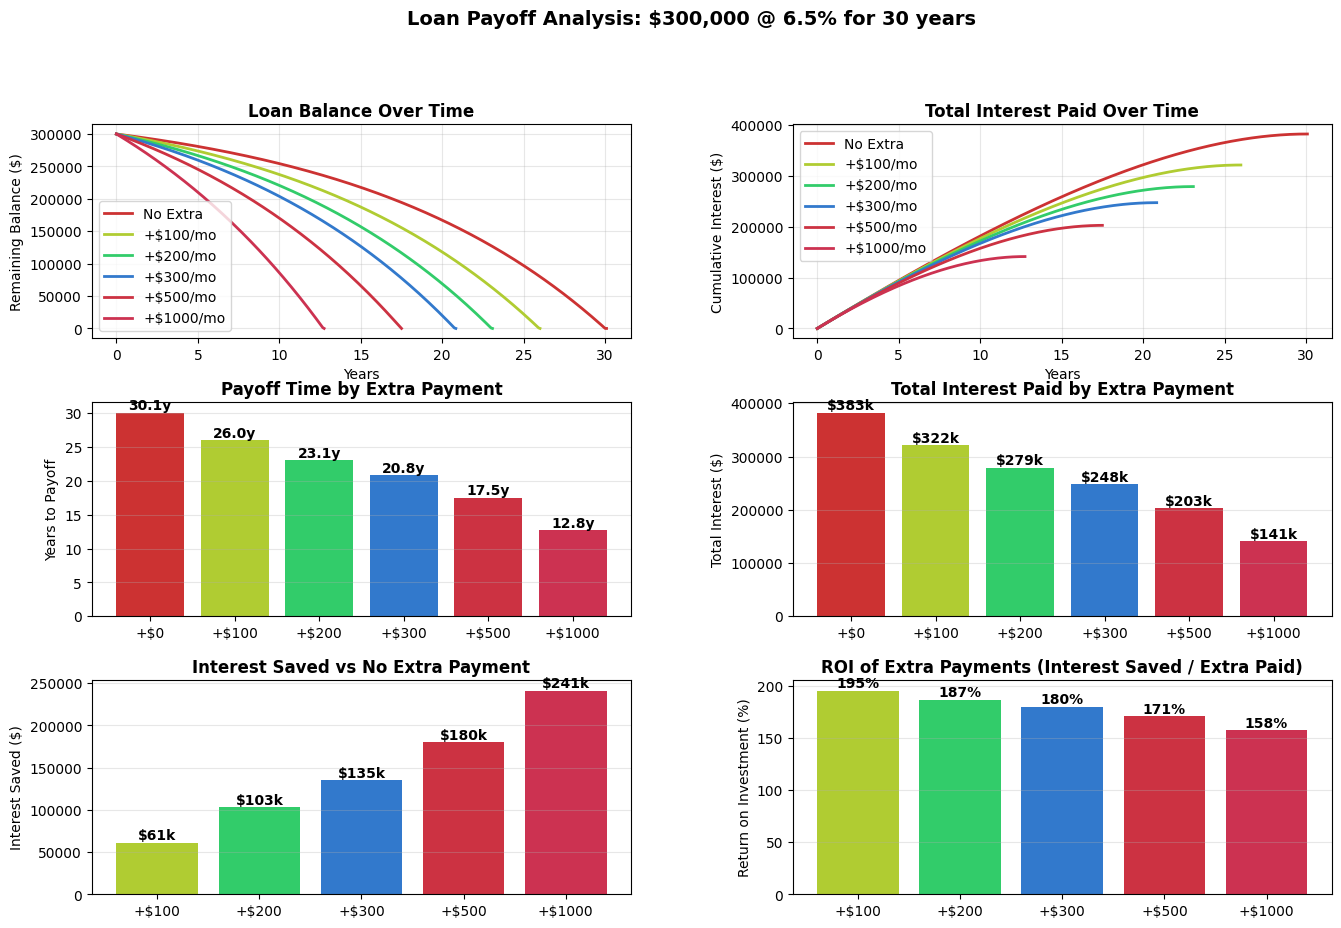


KEY INSIGHTS

With +$100/month:
  • Pay off 4.0 years earlier
  • Save $60,991 in interest
  • Total extra paid: $31,200
  • Net benefit: $29,791

With +$200/month:
  • Pay off 6.9 years earlier
  • Save $103,446 in interest
  • Total extra paid: $55,400
  • Net benefit: $48,046

With +$300/month:
  • Pay off 9.2 years earlier
  • Save $135,113 in interest
  • Total extra paid: $75,000
  • Net benefit: $60,113

With +$500/month:
  • Pay off 12.5 years earlier
  • Save $179,757 in interest
  • Total extra paid: $105,000
  • Net benefit: $74,757

With +$1000/month:
  • Pay off 17.2 years earlier
  • Save $241,160 in interest
  • Total extra paid: $153,000
  • Net benefit: $88,160


In [3]:

# Print comparison table
print('=' * 90)
print('EXTRA PAYMENT COMPARISON')
print('=' * 90)
print(f'{"Extra":<8} {"Total Pmt":<12} {"Years":<8} {"Total Interest":<16} {"Interest Saved":<16} {"Time Saved"}')
print('-' * 90)
for r in results:
    print(f'${r["extra_payment"]:<7.0f} ${r["total_payment"]:<11.2f} {r["years_to_payoff"]:<7.1f} '
          f'${r["total_interest"]:<15,.0f} ${r["interest_saved"]:<15,.0f} {r["time_saved_years"]:.1f} years')
print('=' * 90)

# Create visualizations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

def label(a: int) -> str:
    return 'No Extra' if a == 0 else f'+${a}/mo'

def color_for_amount(a: int) -> str:
    # Golden-angle hue for good separation; HLS -> RGB -> hex
    h = (a * 137.508) % 360
    r, g, b = colorsys.hls_to_rgb(h/360.0, 0.5, 0.6)
    return f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'

labels = [label(a) for a in extra_payments]
colors = [color_for_amount(a) for a in extra_payments]

# Plot 1: Balance over time
ax1 = fig.add_subplot(gs[0, 0])
for i, extra in enumerate(extra_payments):
    df = all_data[extra]
    ax1.plot(df['year'], df['balance'], color=colors[i], linewidth=2, label=labels[i])
ax1.set_xlabel('Years')
ax1.set_ylabel('Remaining Balance ($)')
ax1.set_title('Loan Balance Over Time', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative interest
ax2 = fig.add_subplot(gs[0, 1])
for i, extra in enumerate(extra_payments):
    df = all_data[extra]
    ax2.plot(df['year'], df['cumulative_interest'], color=colors[i], linewidth=2, label=labels[i])
ax2.set_xlabel('Years')
ax2.set_ylabel('Cumulative Interest ($)')
ax2.set_title('Total Interest Paid Over Time', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Years to payoff comparison
ax3 = fig.add_subplot(gs[1, 0])
years_list = [r['years_to_payoff'] for r in results]
bars = ax3.bar([f'+${x}' for x in extra_payments], years_list, color=colors)
ax3.set_ylabel('Years to Payoff')
ax3.set_title('Payoff Time by Extra Payment', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}y', ha='center', va='bottom', fontweight='bold')

# Plot 4: Total interest comparison
ax4 = fig.add_subplot(gs[1, 1])
interest_list = [r['total_interest'] for r in results]
bars = ax4.bar([f'+${x}' for x in extra_payments], interest_list, color=colors)
ax4.set_ylabel('Total Interest ($)')
ax4.set_title('Total Interest Paid by Extra Payment', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1000:.0f}k', ha='center', va='bottom', fontweight='bold')

# Plot 5: Interest saved
ax5 = fig.add_subplot(gs[2, 0])
interest_saved = [r['interest_saved'] for r in results[1:]]  # Skip first (no extra)
bars = ax5.bar([f'+${x}' for x in extra_payments[1:]], interest_saved, color=colors[1:])
ax5.set_ylabel('Interest Saved ($)')
ax5.set_title('Interest Saved vs No Extra Payment', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1000:.0f}k', ha='center', va='bottom', fontweight='bold')

# Plot 6: ROI of extra payments
ax6 = fig.add_subplot(gs[2, 1])
roi_data = []
for r in results[1:]:
    total_extra_paid = r['extra_payment'] * r['months_to_payoff']
    roi = (r['interest_saved'] / total_extra_paid) * 100 if total_extra_paid > 0 else 0
    roi_data.append(roi)

bars = ax6.bar([f'+${x}' for x in extra_payments[1:]], roi_data, color=colors[1:])
ax6.set_ylabel('Return on Investment (%)')
ax6.set_title('ROI of Extra Payments (Interest Saved / Extra Paid)', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f'Loan Payoff Analysis: ${principal:,} @ {annual_rate}% for {years} years', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Summary insights
print('\n' + '=' * 90)
print('KEY INSIGHTS')
print('=' * 90)
for i, r in enumerate(results[1:], 1):
    print(f'\nWith +${r["extra_payment"]}/month:')
    print(f'  • Pay off {r["time_saved_years"]:.1f} years earlier')
    print(f'  • Save ${r["interest_saved"]:,.0f} in interest')
    print(f'  • Total extra paid: ${r["extra_payment"] * r["months_to_payoff"]:,.0f}')
    print(f'  • Net benefit: ${r["interest_saved"] - (r["extra_payment"] * r["months_to_payoff"]):,.0f}')